In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/CV-crowd-flow-estimation-/notebooks'
!pwd

/content/drive/MyDrive/CV-crowd-flow-estimation-/notebooks
/content/drive/MyDrive/CV-crowd-flow-estimation-/notebooks


In [4]:
import sys
import os
import torch
import matplotlib.pyplot as plt
# Add project root to sys.path (one directory up from the notebook)
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.data_loader import ShanghaiTechDataModule
from src.train import train_model
from torchvision import transforms
from torchvision.models import get_model

### Resnet Density Map

Using device: cuda
Using CUDA: Tesla T4


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 176MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[resnet50] Epoch 1/10  Train MSE: 0.002959, MAE: 0.001056  Val   MSE: 0.000173, MAE: 0.000298


[resnet50] Epoch 2/10  Train MSE: 0.000158, MAE: 0.000264  Val   MSE: 0.000144, MAE: 0.000279


[resnet50] Epoch 3/10  Train MSE: 0.000131, MAE: 0.000249  Val   MSE: 0.000131, MAE: 0.000263


[resnet50] Epoch 4/10  Train MSE: 0.000119, MAE: 0.000240  Val   MSE: 0.000111, MAE: 0.000249


[resnet50] Epoch 5/10  Train MSE: 0.000100, MAE: 0.000227  Val   MSE: 0.000115, MAE: 0.000252


[resnet50] Epoch 6/10  Train MSE: 0.000088, MAE: 0.000216  Val   MSE: 0.000094, MAE: 0.000228


[resnet50] Epoch 7/10  Train MSE: 0.000079, MAE: 0.000208  Val   MSE: 0.000105, MAE: 0.000236


[resnet50] Epoch 8/10  Train MSE: 0.000079, MAE: 0.000211  Val   MSE: 0.000089, MAE: 0.000222


[resnet50] Epoch 9/10  Train MSE: 0.000079, MAE: 0.000207  Val   MSE: 0.000083, MAE: 0.000221


[resnet50] Epoch 10/10  Train MSE: 0.000083, MAE: 0.000216  Val   MSE: 0.000113, MAE: 0.000245
Saved weights to ../models/pth/part_B_resnet50.pth


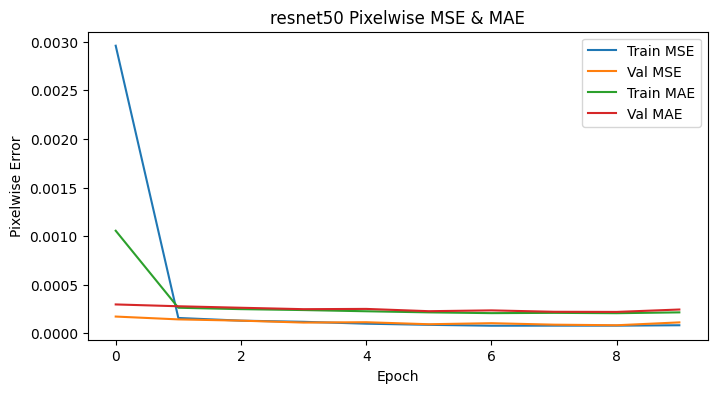

In [5]:
#Train

device = torch.device("cuda" if  torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1) Prepare the data
data_module = ShanghaiTechDataModule(
    data_folder="../data/ShanghaiTech",
    part="part_B",
    validation_split=0.1,
    sigma=5,
    return_count=False,
    batch_size=8,
    num_workers=4,
    density_map_size=(192, 192),
)

# 2) Train the model (15 epochs)
train_model(
    data_module,
    model_name="resnet50",
    epochs=10,
    lr=1e-4,
    #batch_size=8,
    pretrained=True,
    save_path="../models/pth/part_B_resnet50.pth"
)


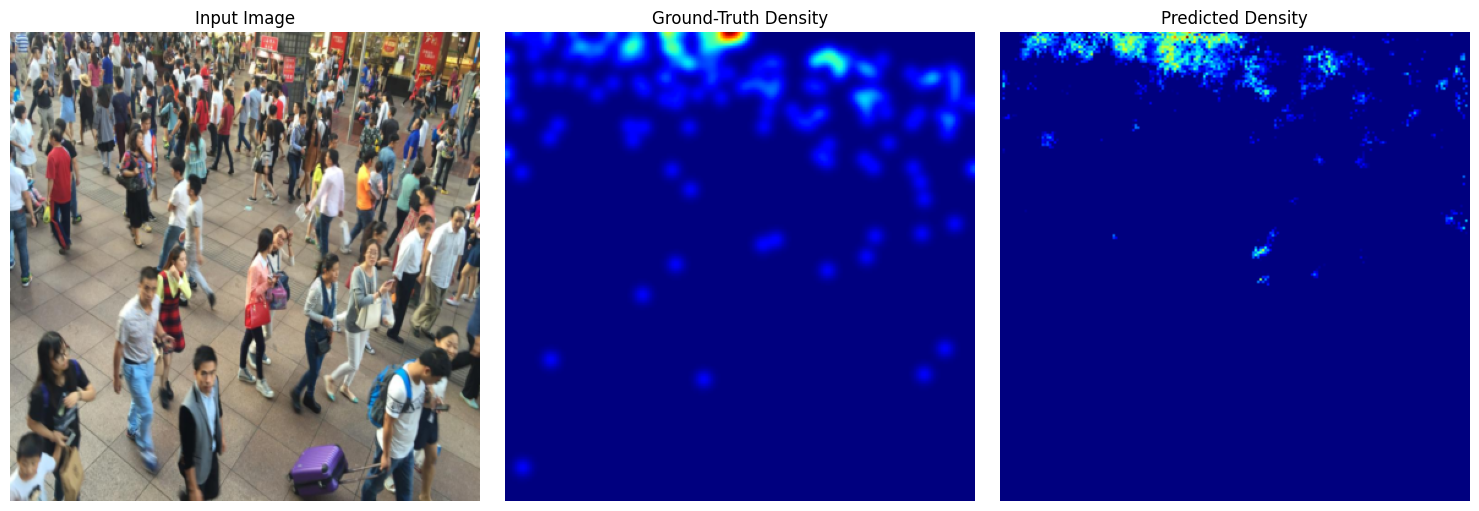

In [9]:
# 3) Load the finetuned model for inference
from models.resnet50_backbone import ResNet50Backbone

model = ResNet50Backbone(pretrained=True)
model.load_state_dict(torch.load("../models/pth/part_B_resnet50.pth", map_location=device))
model.to(device).eval()

# 4) Fetch one sample from the test set
test_loader = data_module.test_dataloader()
imgs, gt_maps = next(iter(test_loader))   # imgs: [B,3,H,W], gt_maps: [B,1,H,W]
img, gt_map   = imgs[1], gt_maps[1]       # pick first sample

# 5) Run inference
with torch.no_grad():
    input_img = img.unsqueeze(0).to(device)       # [1,3,H,W]
    pred_map  = model(input_img)                  # [1,1,H,W]
    pred_map  = pred_map.squeeze(0).squeeze(0).cpu().numpy()  # [H,W]

# 6) Plot RGB, ground-truth density, and predicted density
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image
axes[0].imshow(img.permute(1, 2, 0).cpu())
axes[0].set_title("Input Image")
axes[0].axis("off")

# Ground-truth density
axes[1].imshow(gt_map.squeeze(0).cpu().numpy(), cmap="jet")
axes[1].set_title("Ground-Truth Density")
axes[1].axis("off")

# Predicted density
axes[2].imshow(pred_map, cmap="jet")
axes[2].set_title("Predicted Density")
axes[2].axis("off")

plt.tight_layout()
plt.show()


### VGG19bn Density map

Using device: cuda
Using CUDA: Tesla T4


Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:06<00:00, 83.1MB/s]


[vgg19_bn] Epoch 1/10  Train MSE: 0.007579, MAE: 0.002247  Val   MSE: 0.000213, MAE: 0.000339


[vgg19_bn] Epoch 2/10  Train MSE: 0.000199, MAE: 0.000283  Val   MSE: 0.000201, MAE: 0.000316


[vgg19_bn] Epoch 3/10  Train MSE: 0.000198, MAE: 0.000280  Val   MSE: 0.000200, MAE: 0.000315


[vgg19_bn] Epoch 4/10  Train MSE: 0.000196, MAE: 0.000282  Val   MSE: 0.000194, MAE: 0.000315


[vgg19_bn] Epoch 5/10  Train MSE: 0.000187, MAE: 0.000286  Val   MSE: 0.000173, MAE: 0.000308


[vgg19_bn] Epoch 6/10  Train MSE: 0.000162, MAE: 0.000273  Val   MSE: 0.000148, MAE: 0.000285


[vgg19_bn] Epoch 7/10  Train MSE: 0.000139, MAE: 0.000256  Val   MSE: 0.000128, MAE: 0.000267


[vgg19_bn] Epoch 8/10  Train MSE: 0.000120, MAE: 0.000242  Val   MSE: 0.000120, MAE: 0.000259


[vgg19_bn] Epoch 9/10  Train MSE: 0.000108, MAE: 0.000230  Val   MSE: 0.000110, MAE: 0.000251


[vgg19_bn] Epoch 10/10  Train MSE: 0.000101, MAE: 0.000225  Val   MSE: 0.000111, MAE: 0.000247
Saved weights to ../models/pth/part_B_vgg19.pth


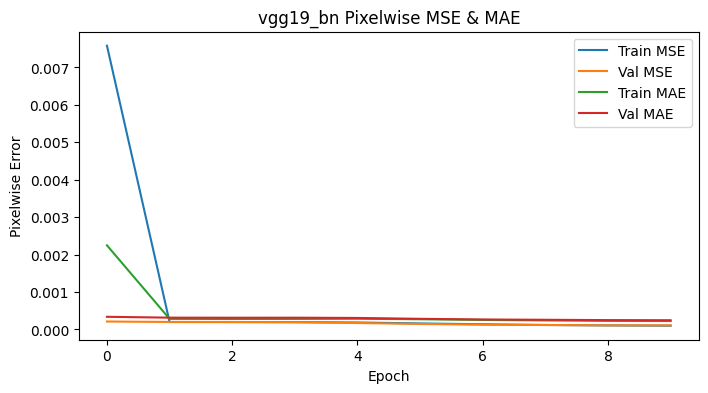

In [7]:
#Train

device = torch.device("cuda" if  torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1) Prepare the data
data_module = ShanghaiTechDataModule(
    data_folder="../data/ShanghaiTech",
    part="part_B",
    validation_split=0.1,
    sigma=5,
    return_count=False,
    batch_size=8,
    num_workers=4,
    density_map_size=(192, 192),
)

# 2) Train the model (15 epochs)
train_model(
    data_module,
    model_name="vgg19_bn",
    epochs=10,
    lr=1e-4,
    #batch_size=8,
    pretrained=True,
    save_path="../models/pth/part_B_vgg19.pth"
)


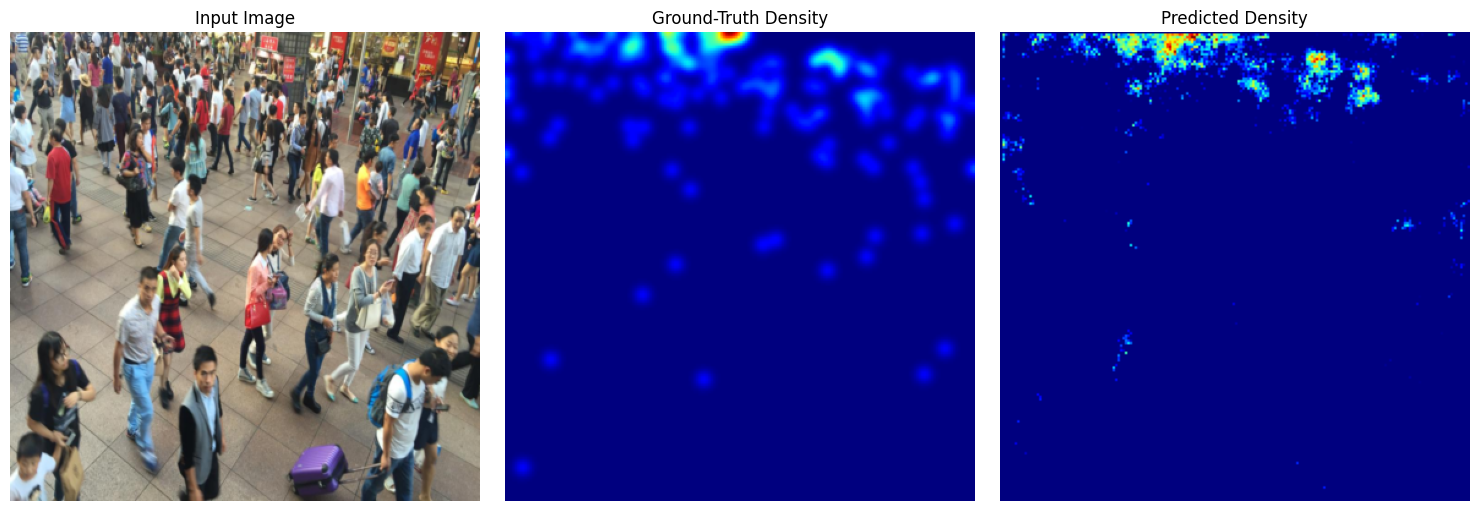

In [10]:
# 3) Load the finetuned model for inference
from models.vgg_backbone import VGG19BNBackbone

model = VGG19BNBackbone(pretrained=True)
model.load_state_dict(torch.load("../models/pth/part_B_vgg19.pth", map_location=device))
model.to(device).eval()

# 4) Fetch one sample from the test set
test_loader = data_module.test_dataloader()
imgs, gt_maps = next(iter(test_loader))   # imgs: [B,3,H,W], gt_maps: [B,1,H,W]
img, gt_map   = imgs[1], gt_maps[1]       # pick first sample

# 5) Run inference
with torch.no_grad():
    input_img = img.unsqueeze(0).to(device)       # [1,3,H,W]
    pred_map  = model(input_img)                  # [1,1,H,W]
    pred_map  = pred_map.squeeze(0).squeeze(0).cpu().numpy()  # [H,W]

# 6) Plot RGB, ground-truth density, and predicted density
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image
axes[0].imshow(img.permute(1, 2, 0).cpu())
axes[0].set_title("Input Image")
axes[0].axis("off")

# Ground-truth density
axes[1].imshow(gt_map.squeeze(0).cpu().numpy(), cmap="jet")
axes[1].set_title("Ground-Truth Density")
axes[1].axis("off")

# Predicted density
axes[2].imshow(pred_map, cmap="jet")
axes[2].set_title("Predicted Density")
axes[2].axis("off")

plt.tight_layout()
plt.show()
